# Assignment #1

## Overview of our assignment
* Given a face image dataset, namely CelebA, you need to perform classification on it, using MLP and multiple CNN architectures, and then report the results.
* We provide three models for classification, such as MLP, VGG, and ResNet-18, which can be used as the base architectures for your assignment.
* You should implement the following three regularization techniques: 1) Dropout, 2) L2 normalization, and 3) L1 normalization, based upon the provided three models, and then report the results. 
* Also, you should implement the following three optimization methods: 1) SGD with Momentum, 2) AdaGrad, and 3) Adam, and then report the obtained results as well.

In [121]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image

## Preparing the CelebA dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Download link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

1) Download and unzip the file `./Img/img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `./Anno/list_attr_celeba.txt` file, which contains the class labels.

3) Download the `./Eval/list_eval_partition.txt` file, which contains  training/validation/test partitioning info.

Please make sure that, all your downloaded files (or unzipped folders) are located inside of the "./data" folder to run below codes.

For example,
* ./data/list_attr_celeba.txt
* ./data/list_eval_partition.txt
* ./data/img_align_celeba/{IMAGE_NAME}.jpg

(218, 178, 3)


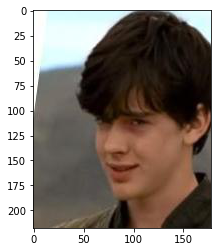

In [3]:
# Print sample image
img = Image.open('./data/img_align_celeba/img_align_celeba/000777.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

## Implementing the DataLoader for training, validation, and test

In [4]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [5]:
custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((32, 32)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

In [6]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

# custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
#                                        transforms.Resize((32, 32)),
#                                        #transforms.Grayscale(),                                       
#                                        #transforms.Lambda(lambda x: x/255.),
#                                        transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='./data/celeba-gender-train.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='./data/celeba-gender-valid.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='./data/celeba-gender-test.csv',
                             img_dir='./data/img_align_celeba/img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=256


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=12)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=12)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=12)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)

cuda:0


In [8]:
# Testing dataloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 256


## Implementing models

In [122]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 10

# Architecture
num_features = 32*32
num_classes = 2

In [10]:
from models import vgg

## Define Compute Accuracy Function

In [18]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

## Define Base Model Function

In [43]:
def base_model_function(model, optimizer, num_epoch):
    start_time = time.time()
    
    num_epochs = num_epoch
    for epoch in range(num_epochs):
        # print(epoch)
        running_loss, val_running_loss = 0.0, 0.0
        running_corrects, val_running_corrects = 0.0, 0.0
        num_examples = 0

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ## loss 더해주기
            running_loss += cost.item()

            ## correct 더해주기
            num_examples += targets.size(0)
            running_corrects += (predicted_labels == targets).sum()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, num_epochs, batch_idx, 
                         len(train_loader), cost))

        # epoch loss 계산
        ## print(running_loss)
        ## print(len(train_loader))
        epoch_loss = running_loss/len(train_loader)
        running_loss_history.append(epoch_loss)

        # epoch accuracy 계산
        ## print(running_corrects)
        ## print(num_examples)
        epoch_acc = running_corrects/num_examples * 100
        running_corrects_history.append(epoch_acc)

        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            correct_pred, num_examples = 0, 0
            for i, (features, targets) in enumerate(valid_loader):

                features = features.to(device)
                targets = targets.to(device)

                logits, probas = model(features)
                _, predicted_labels = torch.max(probas, 1)
                cost = F.cross_entropy(logits, targets)

                val_running_loss += cost.item()
                num_examples += targets.size(0)
                val_running_corrects += (predicted_labels == targets).sum()


            # epoch loss 계산
            val_epoch_loss = val_running_loss/len(valid_loader)
            val_running_loss_history.append(val_epoch_loss)

            # epoch accuracy 계산
            val_epoch_acc = val_running_corrects/num_examples * 100
            val_running_corrects_history.append(val_epoch_acc)

            print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
                  epoch+1, num_epochs, 
                  epoch_acc,
                  val_epoch_acc))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

## 1. VGG without any regularization

In [44]:
model = vgg.VGG11()               
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [45]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [46]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.7655
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.4766
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.4079
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.3242
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.3009
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.3208
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.2850
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.2536
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.2527
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.2356
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.2035
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.2037
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.2013
Epoch: 001/010 | Train: 86.478% | Valid: 92.938%
Time elapsed: 0.66 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.1835
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.1796
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.1376
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.2612
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.1690
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.1591
Epoch: 002/010 |

### Evaluation

In [47]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.44%


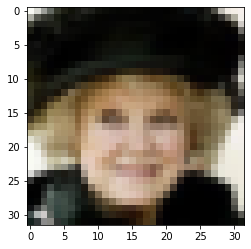

In [48]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [49]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 16.25%


### Visualization

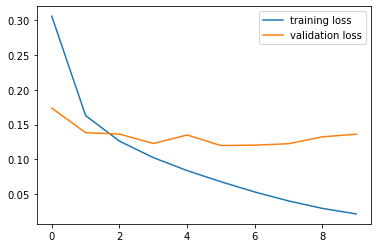

In [50]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

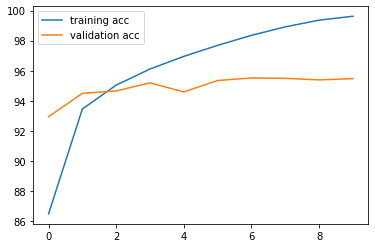

In [51]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 2. VGG with Dropouot

In [123]:
# Source: https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_dout(nn.Module):
    def __init__(self, vgg_name):
        super(VGG_dout, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 2),
            nn.Dropout(0.5) ########### Dropouot 적용 ###########
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)] # Dropouot 적용
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

In [124]:
model = VGG_dout('VGG11')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [125]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [126]:
## model - VGG11 with dropout
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 1.0651
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.5142
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.5180
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.4565
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.4126
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.4092
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.3991
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.3845
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.3892
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.4090
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.3506
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.3594
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.3449
Epoch: 001/010 | Train: 78.546% | Valid: 91.468%
Time elapsed: 0.40 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.3349
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.3455
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.3315
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.3187
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.3420
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.3396
Epoch: 002/010 |

### Evaluation

In [127]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.70%


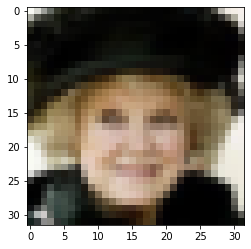

In [128]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [129]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.72%


### Visualization

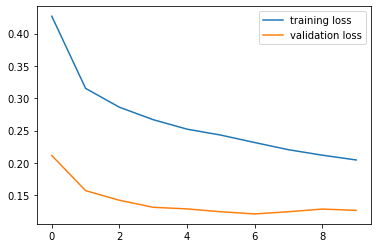

In [130]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

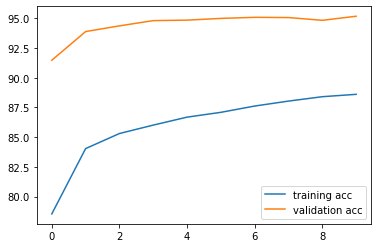

In [131]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 3. VGG11 with Weight Decay(L2 Regularization)

In [61]:
model = vgg.VGG11()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=learning_rate)
# print(model)

In [62]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [63]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.8563
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.4814
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.4356
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.3622
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.4011
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.2924
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.3248
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.2659
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.2612
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.2788
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.2215
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.2104
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.2160
Epoch: 001/010 | Train: 85.783% | Valid: 92.354%
Time elapsed: 0.69 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.1413
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.2112
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.1743
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.1562
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.1526
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.1360
Epoch: 002/010 |

### Evaluation

In [64]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.83%


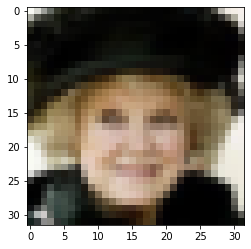

In [65]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [66]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.98%


### Visualization

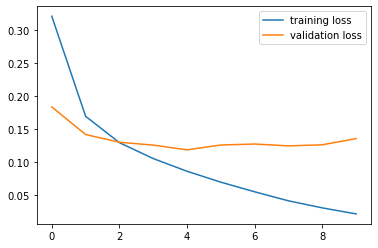

In [67]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

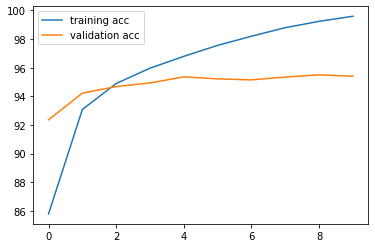

In [68]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 3.1 VGG11 with weight decay(L2 Regularization)  
### 0.01 -> 0.1

In [136]:
model = vgg.VGG11()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.2, lr=learning_rate)
# print(model)

# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [137]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.7489
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.4646
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.4261
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.3600
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.3621
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.3374
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.3023
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.3139
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.2818
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.3055
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.2136
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.2124
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.1639
Epoch: 001/010 | Train: 85.881% | Valid: 92.938%
Time elapsed: 0.38 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.1808
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.1363
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.1508
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.1774
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.1598
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.1058
Epoch: 002/010 |

### Evaluation

In [140]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.76%


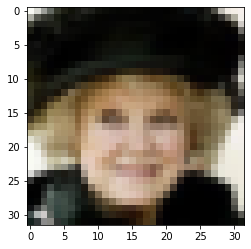

In [141]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [142]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.51%


### Visualization

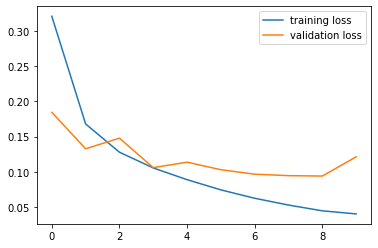

In [138]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

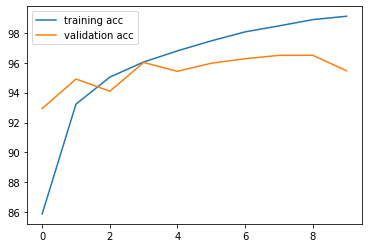

In [139]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 4. VGG11 with L1 Regularization

In [151]:
# Source: https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    ### Add compute_l1_loss / compute_l2_loss function
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

In [156]:
model = VGG('VGG11')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [157]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [160]:
# VGG11 with L1 Regularization
start_time = time.time()
num_epochs = 10
for epoch in range(num_epochs):
    ## print(epoch)
    running_loss, val_running_loss = 0.0, 0.0
    running_corrects, val_running_corrects = 0.0, 0.0
    num_examples = 0
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)
        l1_regularization = torch.tensor(0).to(device)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        l1_weight = 0.001
        l1_parameters = []
        for param in model.parameters():
            l1_parameters.append(param.view(-1))
        l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))

        cost = cost + l1
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ## loss 더해주기
        running_loss += cost.item()
        
        ## correct 더해주기
        num_examples += targets.size(0)
        running_corrects += (predicted_labels == targets).sum()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    # epoch loss 계산
    ## print(running_loss)
    ## print(len(train_loader))
    epoch_loss = running_loss/len(train_loader)
    running_loss_history.append(epoch_loss)
    
    # epoch accuracy 계산
    ## print('num_examples :', num_examples)
    ## print('correct_pred :', running_corrects)
    epoch_acc = running_corrects.float()/num_examples * 100
    running_corrects_history.append(epoch_acc)
        
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        val_running_corrects, val_num_examples = 0, 0
        for i, (features, targets) in enumerate(valid_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)
            cost = F.cross_entropy(logits, targets)
            
            l1_weight = 0.001
            l1_parameters = []
            for param in model.parameters():
                l1_parameters.append(param.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))

            cost = cost + l1
            
            val_running_loss += cost.item()
            val_num_examples += targets.size(0)
            val_running_corrects += (predicted_labels == targets).sum()
            
        # epoch loss 계산
        val_epoch_loss = val_running_loss/len(valid_loader)
        val_running_loss_history.append(val_epoch_loss)

        # epoch accuracy 계산
        ## print('num_examples :', val_num_examples)
        ## print('correct_pred :', val_running_corrects)
        val_epoch_acc = val_running_corrects.float()/val_num_examples * 100
        val_running_corrects_history.append(val_epoch_acc)
        
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, 
              epoch_acc,
              val_epoch_acc))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0636 | Cost: 1.9942
Epoch: 001/010 | Batch 0050/0636 | Cost: 1.5904
Epoch: 001/010 | Batch 0100/0636 | Cost: 1.6033
Epoch: 001/010 | Batch 0150/0636 | Cost: 1.5901
Epoch: 001/010 | Batch 0200/0636 | Cost: 1.5923
Epoch: 001/010 | Batch 0250/0636 | Cost: 1.5873
Epoch: 001/010 | Batch 0300/0636 | Cost: 1.5848
Epoch: 001/010 | Batch 0350/0636 | Cost: 1.5908
Epoch: 001/010 | Batch 0400/0636 | Cost: 1.5745
Epoch: 001/010 | Batch 0450/0636 | Cost: 1.5932
Epoch: 001/010 | Batch 0500/0636 | Cost: 1.5892
Epoch: 001/010 | Batch 0550/0636 | Cost: 1.5704
Epoch: 001/010 | Batch 0600/0636 | Cost: 1.5826
Epoch: 001/010 | Train: 58.063% | Valid: 57.427%
Time elapsed: 0.39 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 1.5630
Epoch: 002/010 | Batch 0050/0636 | Cost: 1.5441
Epoch: 002/010 | Batch 0100/0636 | Cost: 1.5616
Epoch: 002/010 | Batch 0150/0636 | Cost: 1.5627
Epoch: 002/010 | Batch 0200/0636 | Cost: 1.5614
Epoch: 002/010 | Batch 0250/0636 | Cost: 1.5550
Epoch: 002/010 |

### Evaluation

In [146]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 61.35%


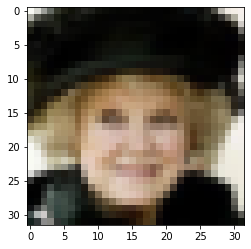

In [147]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [148]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 50.01%


### Visualization

In [118]:
running_loss_history

[76.835198624329,
 71.06097342533135,
 65.62422670208433,
 60.435887450692036,
 55.48763806565003,
 50.77576765024437,
 46.30169065943304,
 42.06335953646486,
 38.06194209452695,
 34.29854060119053]

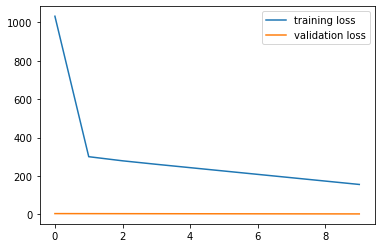

In [149]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

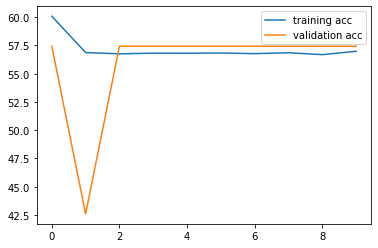

In [150]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()